--- Loading and Preparing Data ---
Data Loaded. Train Shape: (1382, 6), Test Shape: (346, 6)

>>> 1. Training Naive Bayes (From Scratch)...
Sample Predictions:
   Actual  Predicted
0       0          0
1       1          0
2       0          0
3       1          1
4       0          0
5       1          0
6       0          0
7       0          0
8       0          0
9       0          0

--- Naive Bayes (Train) Performance ---
Accuracy:     0.8669
Sensitivity:  0.6434 (Recall)
Specificity:  0.9261
Precision:    0.8179
F1 Score:     0.7032
Confusion Matrix (Rows=Actual, Cols=Predicted):
[[941  32   2   0]
 [ 83 210   8   0]
 [  0  39  19   0]
 [  0  20   0  28]]
------------------------------

--- Naive Bayes (Test) Performance ---
Accuracy:     0.8179
Sensitivity:  0.5592 (Recall)
Specificity:  0.8965
Precision:    0.7700
F1 Score:     0.6188
Confusion Matrix (Rows=Actual, Cols=Predicted):
[[227   8   0   0]
 [ 34  46   3   0]
 [  0   7   4   0]
 [  0  11   0   6]]
-------------------

/tmp/ipykernel_30229/907467673.py:31: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(map_dict)


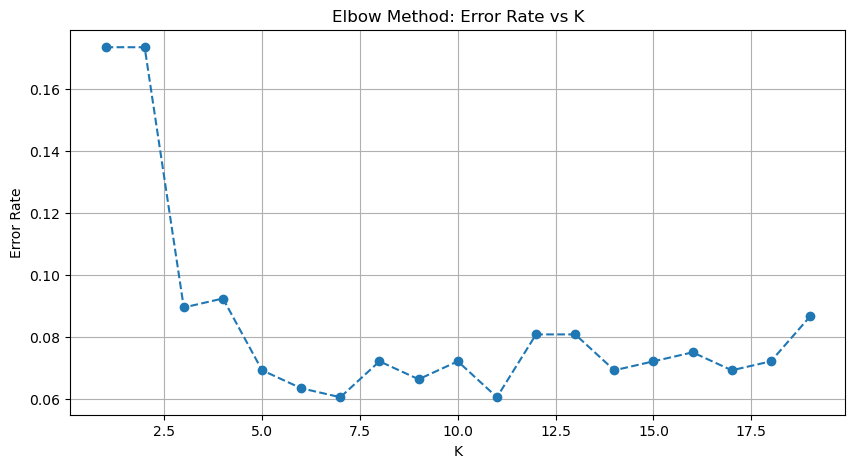


>>> 4. Comparison with Sklearn Built-ins...
Sklearn NB Accuracy:  0.6879
My NB Accuracy:       0.8179
--------------------
Sklearn KNN Accuracy: 0.9393


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE

print("--- Loading and Preparing Data ---")

columns = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']
try:
    df = pd.read_csv('car.data', names=columns)
except FileNotFoundError:
    print("ERROR: 'car.data' not found.")

# label encoding
mappings = {
    'buying':   {'low': 0, 'med': 1, 'high': 2, 'vhigh': 3},
    'maint':    {'low': 0, 'med': 1, 'high': 2, 'vhigh': 3},
    'doors':    {'2': 2, '3': 3, '4': 4, '5more': 5},
    'persons':  {'2': 2, '4': 4, 'more': 6},
    'lug_boot': {'small': 0, 'med': 1, 'big': 2},
    'safety':   {'low': 0, 'med': 1, 'high': 2},
    'class':    {'unacc': 0, 'acc': 1, 'good': 2, 'vgood': 3}
}

for col, map_dict in mappings.items():
    df[col] = df[col].replace(map_dict)

X = df.drop('class', axis=1).values
y = df['class'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Data Loaded. Train Shape: {X_train.shape}, Test Shape: {X_test.shape}")

#metric calculator
def calculate_metrics(y_true, y_pred, model_name="Model"):
    # Overall Accuracy
    accuracy = np.mean(y_true == y_pred)
    
    classes = np.unique(y_true)
    precisions, recalls, f1s, specificities = [], [], [], []
    
    for c in classes:
        tp = np.sum((y_pred == c) & (y_true == c))
        fp = np.sum((y_pred == c) & (y_true != c))
        fn = np.sum((y_pred != c) & (y_true == c))
        tn = np.sum((y_pred != c) & (y_true != c))
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0 # Sensitivity
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        precisions.append(precision)
        recalls.append(recall)
        specificities.append(specificity)
        f1s.append(f1)
        
    print(f"\n--- {model_name} Performance ---")
    print(f"Accuracy:     {accuracy:.4f}")
    print(f"Sensitivity:  {np.mean(recalls):.4f} (Recall)")
    print(f"Specificity:  {np.mean(specificities):.4f}")
    print(f"Precision:    {np.mean(precisions):.4f}")
    print(f"F1 Score:     {np.mean(f1s):.4f}")
    
    # Construct Confusion Matrix (Simple text version)
    print("Confusion Matrix (Rows=Actual, Cols=Predicted):")
    n_classes = len(np.unique(y))
    matrix = np.zeros((n_classes, n_classes), dtype=int)
    for t, p in zip(y_true, y_pred):
        matrix[t, p] += 1
    print(matrix)
    print("-" * 30)
    return accuracy

# naive bayes
class NaiveBayesScratch:
    def fit(self, X, y):
        self.classes = np.unique(y)
        self.priors = {}
        self.likelihoods = {}
        n_samples = X.shape[0]
        
        for c in self.classes:
            X_c = X[y == c]
            self.priors[c] = X_c.shape[0] / n_samples
            self.likelihoods[c] = []
            for col_idx in range(X.shape[1]):
                counts = dict(Counter(X_c[:, col_idx]))
                total = X_c.shape[0]
                probs = {k: v / total for k, v in counts.items()}
                self.likelihoods[c].append(probs)
                
    def predict(self, X):
        preds = []
        for sample in X:
            posteriors = []
            for c in self.classes:
                posterior = self.priors[c]
                for i, val in enumerate(sample):
                    prob = self.likelihoods[c][i].get(val, 1e-6)
                    posterior *= prob
                posteriors.append(posterior)
            preds.append(self.classes[np.argmax(posteriors)])
        return np.array(preds)

print("\n>>> 1. Training Naive Bayes (From Scratch)...")
nb = NaiveBayesScratch()
nb.fit(X_train, y_train)

y_pred_nb = nb.predict(X_test)
results_df = pd.DataFrame({'Actual': y_test[:10], 'Predicted': y_pred_nb[:10]})
print("Sample Predictions:")
print(results_df)

calculate_metrics(y_train, nb.predict(X_train), "Naive Bayes (Train)")
calculate_metrics(y_test, y_pred_nb, "Naive Bayes (Test)")

# smote
print("\n>>> 2. Applying SMOTE for Class Imbalance...")
sm = SMOTE(random_state=42)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

print(f"Original Train Count: {len(X_train)}")
print(f"SMOTE Train Count:    {len(X_train_smote)}")

# Re-build model with SMOTE data
nb_smote = NaiveBayesScratch()
nb_smote.fit(X_train_smote, y_train_smote)
y_pred_smote = nb_smote.predict(X_test)

print("Comparing Results:")
calculate_metrics(y_test, y_pred_nb, "Without SMOTE")
calculate_metrics(y_test, y_pred_smote, "With SMOTE")

# KNN Classifier
class KNNScratch:
    def __init__(self, k=3):
        self.k = k
        
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        
    def predict(self, X):
        preds = []
        for sample in X:
            # Euclidean Distance
            dists = np.sqrt(np.sum((self.X_train - sample)**2, axis=1))
            # Get k nearest indices
            k_indices = np.argsort(dists)[:self.k]
            k_labels = self.y_train[k_indices]
            # Majority Vote
            common = Counter(k_labels).most_common(1)[0][0]
            preds.append(common)
        return np.array(preds)

print("\n>>> 3. K-NN Classifier Experiments...")

N = X_train.shape[0]
k_scenarios = [1, int(np.sqrt(N)), 60]

for k in k_scenarios:
    knn = KNNScratch(k=k)
    knn.fit(X_train, y_train)
    y_pred_k = knn.predict(X_test)
    calculate_metrics(y_test, y_pred_k, f"KNN (k={k})")

print("\nGenerating Elbow Method Plot...")
errors = []
k_range = range(1, 20)
for k in k_range:
    knn = KNNScratch(k=k)
    knn.fit(X_train, y_train)
    pred = knn.predict(X_test)
    errors.append(np.mean(pred != y_test))



plt.figure(figsize=(10, 5))
plt.plot(k_range, errors, marker='o', linestyle='--')
plt.title('Elbow Method: Error Rate vs K')
plt.xlabel('K')
plt.ylabel('Error Rate')
plt.grid(True)
plt.show()

# comparison with built in
print("\n>>> 4. Comparison with Sklearn Built-ins...")

# Built-in Naive Bayes
sk_nb = GaussianNB()
sk_nb.fit(X_train, y_train)
sk_acc_nb = accuracy_score(y_test, sk_nb.predict(X_test))

# Built-in KNN (using k=5 default)
sk_knn = KNeighborsClassifier(n_neighbors=5)
sk_knn.fit(X_train, y_train)
sk_acc_knn = accuracy_score(y_test, sk_knn.predict(X_test))

print(f"Sklearn NB Accuracy:  {sk_acc_nb:.4f}")
print(f"My NB Accuracy:       {accuracy_score(y_test, y_pred_nb):.4f}")
print("-" * 20)
print(f"Sklearn KNN Accuracy: {sk_acc_knn:.4f}")